In [2]:
!pip install ucimlrepo

In [3]:
#libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split
from ucimlrepo import fetch_ucirepo # original data in https://archive.ics.uci.edu/dataset/222/bank+marketing

In [4]:
!wget https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip /content/bank+marketing.zip
!unzip /content/bank-additional.zip

--2024-12-01 14:48:50--  https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank+marketing.zip’

bank+marketing.zip      [ <=>                ] 999.85K  5.96MB/s    in 0.2s    

2024-12-01 14:48:50 (5.96 MB/s) - ‘bank+marketing.zip’ saved [1023843]

Archive:  /content/bank+marketing.zip
 extracting: bank.zip                
 extracting: bank-additional.zip     
Archive:  /content/bank-additional.zip
   creating: bank-additional/
  inflating: bank-additional/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/bank-additional/
  inflating: __MACOSX/bank-additional/._.DS_Store  
  inflating: bank-additional/.Rhistory  
  inflating: bank-additional/bank-additional-full.csv  
  inflating: bank-additional/bank-additional-names.txt  
  inf

In [5]:
#overall parameters
seed = 1993

In [6]:
bank = pd.read_csv('/content/bank-additional/bank-additional-full.csv', sep=';', )
print(bank.head())

# fetch dataset
# bank-additional-full = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank.loc[:, bank.columns != 'y'] #data features
y = bank[['y']] #data targets

print('Tipo de X:', type(X))
print('Tipo de y:', type(y))
print('Shape de X:', X.shape)
print('Shape de y:', y.shape)

   age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed

# Input:

## bank client data:
1 - age (numeric)

2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student","blue-collar","self-employed","retired","technician","services")

3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)

4 - education (categorical: "unknown","secondary","primary","tertiary")

5 - default: has credit in default? (binary: "yes","no")

6 - balance: average yearly balance, in euros (numeric)

7 - housing: has housing loan? (binary: "yes","no")

8 - loan: has personal loan? (binary: "yes","no")

## related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone", "cellular")

10 - day: last contact day of the month (numeric)

11 - month: last contact month of year (categorical: "jan", "feb", "mar", ...,"nov", "dec")

12 - duration: last contact duration, in seconds (numeric)

## other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)

15 - previous: number of contacts performed before this campaign and for this client (numeric)

16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

## Output variable (desired target):
17 - y - has the client subscribed a term deposit? (binary: "yes","no")

In [7]:
poutcomes = X[~X.poutcome.isna()].poutcome.apply(lambda x: 1 if x == 'success' else 0)
coutcomes = y.y.apply(lambda x: 1 if x == 'yes' else 0)

print('Number of records:', len(X))
print('Success Rate (Current Campaign):', coutcomes.sum() / len(X))
print('Success Rate (Previous Campaign):', poutcomes.sum() / len(poutcomes))

Number of records: 41188
Success Rate (Current Campaign): 0.11265417111780131
Success Rate (Previous Campaign): 0.033334951927745944


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed, shuffle=True, test_size=.1)

print('Number of training records:', len(X_train))
print('Training proportions:\n\n', y_train.value_counts() / len(y_train))
print('\n\n')
print('Number of test records:', len(X_test))
print('Test proportions:\n\n', y_test.value_counts() / len(y_test))

Number of training records: 37069
Training proportions:

 y  
no     0.886941
yes    0.113059
Name: count, dtype: float64



Number of test records: 4119
Test proportions:

 y  
no     0.890993
yes    0.109007
Name: count, dtype: float64


In [11]:
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
print('Train dataset A shape:', df_train.shape)
print('Test dataset shape:', df_test.shape)

dtypes = pd.DataFrame(df_train.dtypes.rename('type')).reset_index().astype('str')

# Exclusão da variável 'duration' por ser leaky.
dtypes = dtypes.query('index != "duration"')
# O uso de informações no processo de treinamento do modelo que não se esperaria
# que estivessem disponíveis no momento da previsão

numeric = dtypes[(dtypes.type.isin(['int64', 'float64'])) & (dtypes['index'] != 'duration')]['index'].values
categorical = dtypes[~(dtypes['index'].isin(numeric)) & (dtypes['index'] != 'y')]['index'].values

print('Numeric:\n', numeric)
print('Categorical:\n', categorical)

Train dataset A shape: (37069, 21)
Test dataset shape: (4119, 21)
Numeric:
 ['age' 'campaign' 'pdays' 'previous' 'emp.var.rate' 'cons.price.idx'
 'cons.conf.idx' 'euribor3m' 'nr.employed']
Categorical:
 ['job' 'marital' 'education' 'default' 'housing' 'loan' 'contact' 'month'
 'day_of_week' 'poutcome']


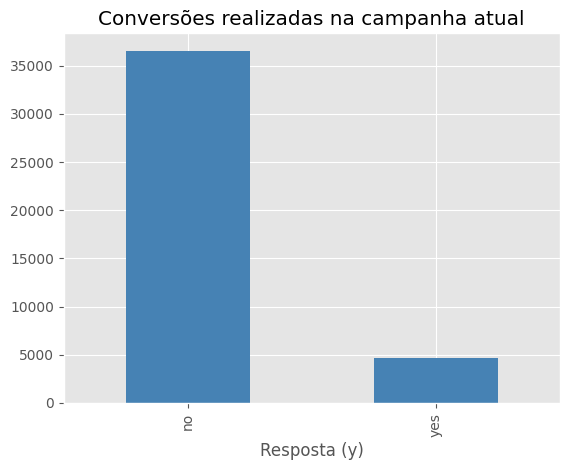

In [34]:
plt.figure()
y['y'].value_counts().plot(kind='bar', color='steelblue');
plt.title('Conversões realizadas na campanha atual');
plt.xlabel('Resposta (y)');

Text(0.5, 0, 'Resposta campanha anterior')

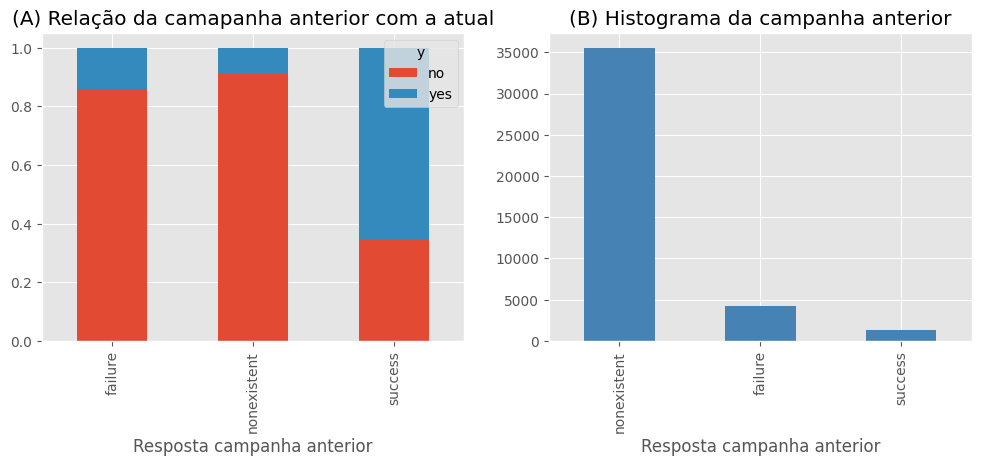

In [50]:
df_bank = pd.concat([df_train, df_test])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
outcome_counts = df_bank.groupby(['poutcome', 'y']).size().rename('count').reset_index()
by_outcome = outcome_counts.pivot(columns='y', values='count', index='poutcome')
# Plot the proportions
by_outcome.div(by_outcome.sum(1), axis=0).plot.bar(stacked=True, ax=ax1);
# Plot the counts
df_bank['poutcome'].value_counts().plot.bar(ax=ax2, legend=False,color='steelblue');
#print(df_bank['poutcome'].value_counts(), '\n')
ax1.set_title('(A) Relação da camapanha anterior com a atual')
ax2.set_title('(B) Histograma da campanha anterior')

ax1.set_xlabel('Resposta campanha anterior')
ax2.set_xlabel('Resposta campanha anterior')

In [12]:
#subset df_train
# Separate the DataFrame into two groups: 'yes' and 'no'
yes_df = df_train[df_train['y'] == 'yes']
no_df = df_train[df_train['y'] == 'no']

# Determine the minimum size between the two groups
min_size = min(len(yes_df), len(no_df))

# Randomly sample rows from each group
balanced_yes_df = yes_df.sample(n=min_size, random_state=seed)
balanced_no_df = no_df.sample(n=min_size, random_state=seed)

# Combine the sampled DataFrames
df_train_subset = pd.concat([balanced_yes_df, balanced_no_df])

# Output the result
print('Train dataset B shape:', df_train_subset.shape)
del yes_df, no_df, min_size, balanced_yes_df, balanced_no_df


Train dataset B shape: (8382, 21)


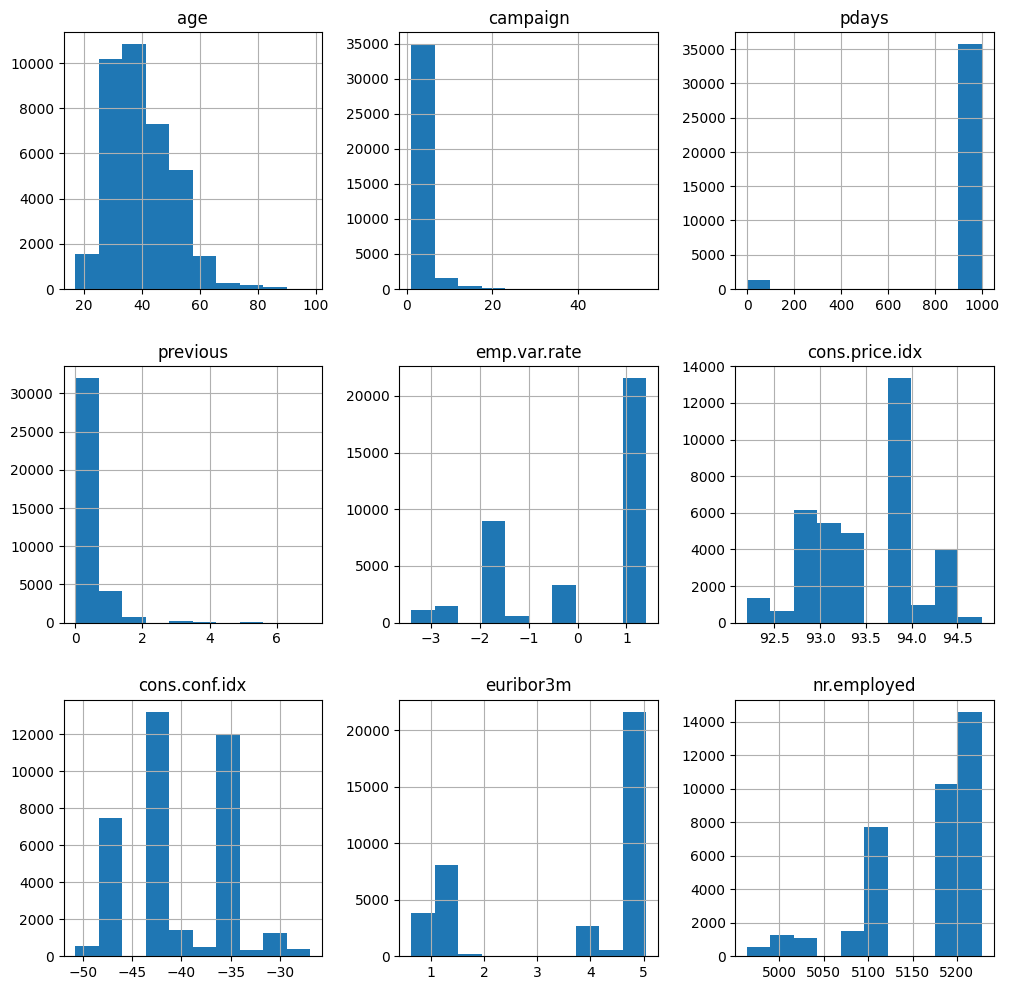

In [13]:
df_train[numeric].hist(figsize=(12,12));

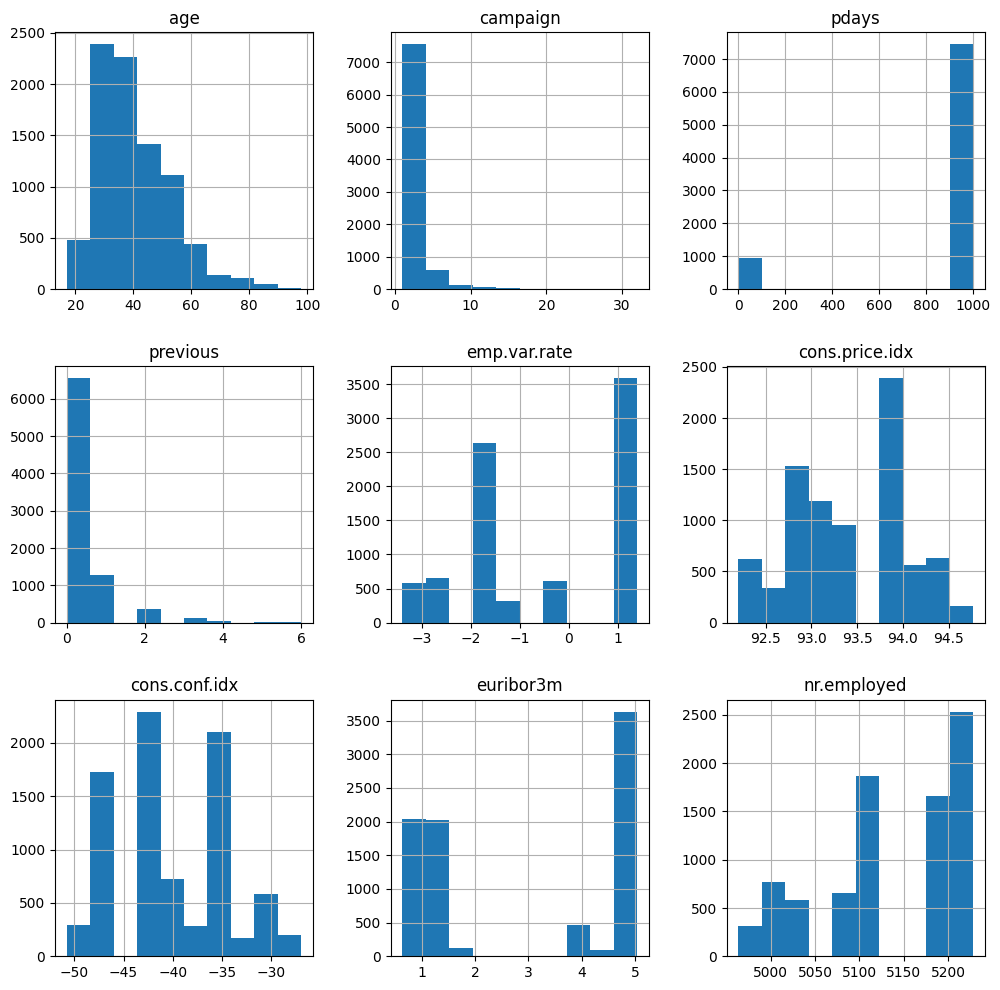

In [14]:
df_train_subset[numeric].hist(figsize=(12,12));

In [186]:
#Continua
#https://github.com/calvdee/end-to-end-lead-scoring/tree/main/notebooks

In [15]:
def preprocess_data(data):
  from sklearn.preprocessing import OneHotEncoder
  from sklearn.preprocessing import StandardScaler

  #numeric = ['age','balance','day_of_week','campaign','pdays','previous']
  numeric = ['age','campaign','pdays','previous','emp.var.rate','cons.price.idx','cons.conf.idx','euribor3m','nr.employed']
  categorical = ['job','marital','education','default','housing','loan','contact','month','day_of_week', 'poutcome']

  df = data[categorical].copy()

  #creating instance of one-hot-encoder
  encoder = OneHotEncoder(handle_unknown='ignore')

  #perform one-hot encoding on 'job' column
  ohe_job = pd.DataFrame(data = encoder.fit_transform(df[['job']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_job.drop('job_unknown', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'marital' column
  ohe_marital = pd.DataFrame(data = encoder.fit_transform(df[['marital']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_marital.drop('marital_unknown', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'education' column
  ohe_education = pd.DataFrame(data = encoder.fit_transform(df[['education']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_education.drop('education_unknown', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'default' column
  ohe_default = pd.DataFrame(data = encoder.fit_transform(df[['default']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_default.drop('default_unknown', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'housing' column
  ohe_housing = pd.DataFrame(data = encoder.fit_transform(df[['housing']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_housing.drop('housing_unknown', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'loan' column
  ohe_loan = pd.DataFrame(data = encoder.fit_transform(df[['loan']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_loan.drop('loan_unknown', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'month' column
  ohe_month = pd.DataFrame(data = encoder.fit_transform(df[['month']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_month.drop('month_may', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'day_of_week' column
  ohe_day_of_week = pd.DataFrame(data = encoder.fit_transform(df[['day_of_week']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_day_of_week.drop('day_of_week_mon', axis=1, inplace=True) # Removing dummy trap

  #perform one-hot encoding on 'poutcome' column
  ohe_poutcome = pd.DataFrame(data = encoder.fit_transform(df[['poutcome']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_poutcome.drop('poutcome_nonexistent', axis=1, inplace=True) # Removing dummy trap

  df_cat = pd.concat([ohe_job, ohe_marital, ohe_education, ohe_housing, ohe_loan, ohe_month, ohe_day_of_week, ohe_poutcome], axis = 1) #w/o ohe_default

  del ohe_job, ohe_marital, ohe_education, ohe_default, ohe_housing, ohe_loan, ohe_month, ohe_day_of_week, ohe_poutcome, df

  df = data[numeric].copy()

  # Normalizar os dados para facilitar o treinamento da rede
  scaler = StandardScaler()
  df_num = pd.DataFrame(data = scaler.fit_transform(df),
                        columns = scaler.get_feature_names_out())

  del df, scaler

  df = data[['y']].copy()

  #perform one-hot encoding on 'poutcome' column
  ohe_y = pd.DataFrame(data = encoder.fit_transform(df[['y']]).toarray(),
                            columns = encoder.get_feature_names_out())
  ohe_y.drop('y_no', axis=1, inplace=True) # Removing dummy trap

  df_y = ohe_y
  df_X = pd.concat([df_num, df_cat], axis = 1)

  del ohe_y, df_num, df_cat

  return df_X, df_y

In [16]:
pp_x_train, pp_y_train = preprocess_data(df_train)
pp_x_train_st, pp_y_train_st = preprocess_data(df_train_subset)
pp_x_test, pp_y_test = preprocess_data(df_test)

print('Train preprocessed X-set shape:', pp_x_train.shape)
print('Train preprocessed y-set shape:', pp_y_train.shape)
print('Train preprocessed smaller X-set shape:', pp_x_train_st.shape)
print('Train preprocessed smaller y-set shape:', pp_y_train_st.shape)
print('Test preprocessed X-set shape:', pp_x_test.shape)
print('Test preprocessed y-set shape:', pp_y_test.shape)

Train preprocessed X-set shape: (37069, 49)
Train preprocessed y-set shape: (37069, 1)
Train preprocessed smaller X-set shape: (8382, 49)
Train preprocessed smaller y-set shape: (8382, 1)
Test preprocessed X-set shape: (4119, 49)
Test preprocessed y-set shape: (4119, 1)


In [17]:
print('Colunas de x treino:', pp_x_train.columns)
print('Colunas de x test:', pp_x_train_st.columns)
print('Diferença: ', set(pp_x_train.columns)-set(pp_x_train_st.columns))

Colunas de x treino: Index(['age', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_divorced',
       'marital_married', 'marital_single', 'education_basic.4y',
       'education_basic.6y', 'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'housing_no', 'housing_yes', 'loan_no',
       'loan_yes', 'month_apr', 'month_aug', 'month_dec', 'month_jul',
       'month_jun', 'month_mar', 'month_nov', 'month_oct', 'month_sep',
       'day_of_week_fri', 'day_of_week_thu', 'day_of_week_tue',
       'day_of_week_wed', 'poutcome_failure', 'poutcome_success'],
      dtype='object')
Colunas de x test: Index(['age', '

In [19]:
# Criar um modelo fully conected
model_0 = keras.Sequential([
    keras.layers.Dense(1, activation='sigmoid', input_shape=(pp_x_train.shape[1],))  # 2 classes de saída
])

model_1 = keras.Sequential([
    keras.layers.Dense(40, activation='sigmoid', input_shape=(pp_x_train.shape[1],)),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dense(1, activation='sigmoid')  # 2 classes de saída
])

model_2 = keras.Sequential([
    keras.layers.Dense(49, activation='sigmoid', input_shape=(pp_x_train.shape[1],)),
    Dropout(0.25),
    keras.layers.Dense(49, activation='sigmoid'),
    Dropout(0.25),
    keras.layers.Dense(1, activation='sigmoid')  # 2 classes de saída
])

model_3 = keras.Sequential([
    Dropout(0.2, input_shape=(pp_x_train.shape[1],)),
    keras.layers.Dense(40, activation='sigmoid'),
    Dropout(0.2),
    keras.layers.Dense(32, activation='sigmoid'),
    keras.layers.Dense(1, activation='sigmoid')  # 2 classes de saída
])

model_4 = keras.Sequential([
    Dropout(0.2, input_shape=(pp_x_train.shape[1],)),
    keras.layers.Dense(40, activation='relu'),
    Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')  # 2 classes de saída
])

model_0.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_3.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [20]:
# Treinar o modelo
history_0 = model_0.fit(pp_x_train, pp_y_train, epochs=25, validation_split=0.2)
history_1 = model_1.fit(pp_x_train_st, pp_y_train_st, epochs=25, validation_split=0.2)
history_2 = model_2.fit(pp_x_train, pp_y_train, epochs=75, validation_split=0.1)
history_3 = model_3.fit(pp_x_train_st, pp_y_train_st, epochs=75, validation_split=0.2)
history_4 = model_4.fit(pp_x_train_st, pp_y_train_st, epochs=75, validation_split=0.2)


Epoch 1/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8355 - loss: 0.4388 - val_accuracy: 0.8941 - val_loss: 0.2995
Epoch 2/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8981 - loss: 0.2946 - val_accuracy: 0.8952 - val_loss: 0.2942
Epoch 3/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9032 - loss: 0.2777 - val_accuracy: 0.8959 - val_loss: 0.2923
Epoch 4/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.8950 - loss: 0.2923 - val_accuracy: 0.8959 - val_loss: 0.2911
Epoch 5/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8976 - loss: 0.2874 - val_accuracy: 0.8955 - val_loss: 0.2900
Epoch 6/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9000 - loss: 0.2813 - val_accuracy: 0.8960 - val_loss: 0.2895
Epoch 7/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8981 - loss: 0.2797 - val_accuracy: 0.8957 - val_loss: 0.2886
Epoch 8/25
927/927 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9020 - loss: 0.2757 - val_accuracy: 0.

In [51]:
# Avaliar o modelo no conjunto de teste
test_loss, test_acc = model_0.evaluate(pp_x_test, pp_y_test)
print(f"Acurácia no teste com modelo 0: {test_acc:.3f}")
print(f"Loss no teste com modelo 0: {test_loss:.3f}")

test_loss, test_acc = model_1.evaluate(pp_x_test, pp_y_test)
print(f"Acurácia no teste com modelo 1: {test_acc:.3f}")
print(f"Loss no teste com modelo 1: {test_loss:.3f}")

test_loss, test_acc = model_2.evaluate(pp_x_test, pp_y_test)
print(f"Acurácia no teste com modelo 2: {test_acc:.3f}")
print(f"Loss no teste com modelo 2: {test_loss:.3f}")

test_loss, test_acc = model_3.evaluate(pp_x_test, pp_y_test)
print(f"Acurácia no teste com modelo 3: {test_acc:.3f}")
print(f"Loss no teste com modelo 3: {test_loss:.3f}")

test_loss, test_acc = model_4.evaluate(pp_x_test, pp_y_test)
print(f"Acurácia no teste com modelo 4: {test_acc:.3f}")
print(f"Loss no teste com modelo 4: {test_loss:.3f}")

del test_loss, test_acc

129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8974 - loss: 0.2839
Acurácia no teste com modelo 0: 0.900
Loss no teste com modelo 0: 0.278
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.5702 - loss: 0.8651
Acurácia no teste com modelo 1: 0.580
Loss no teste com modelo 1: 0.848
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8971 - loss: 0.2772
Acurácia no teste com modelo 2: 0.901
Loss no teste com modelo 2: 0.273
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6840 - loss: 0.7852
Acurácia no teste com modelo 3: 0.695
Loss no teste com modelo 3: 0.768
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6816 - loss: 0.7751
Acurácia no teste com modelo 4: 0.692
Loss no teste com modelo 4: 0.755


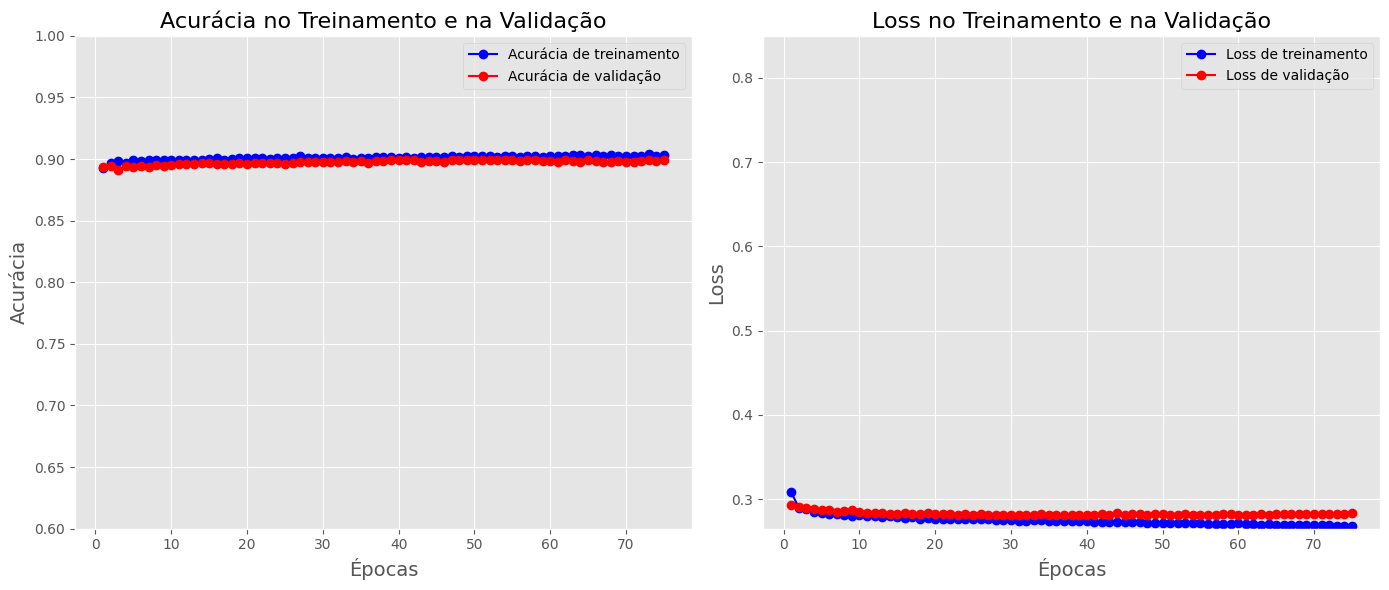

In [27]:
import matplotlib.pyplot as plt

history = history_2

# Suponha que 'history' é o retorno da função fit() do seu modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Configurações gerais de estilo
plt.style.use('ggplot')

# Plot da precisão
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='blue', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'o-', color='red', label='Acurácia de validação')
plt.title('Acurácia no Treinamento e na Validação', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(0.6,1)

# Plot da perda
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='blue', label='Loss de treinamento')
plt.plot(epochs, val_loss, 'o-', color='red', label='Loss de validação')
plt.title('Loss no Treinamento e na Validação', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(0.265,0.85)

plt.tight_layout()
plt.show()

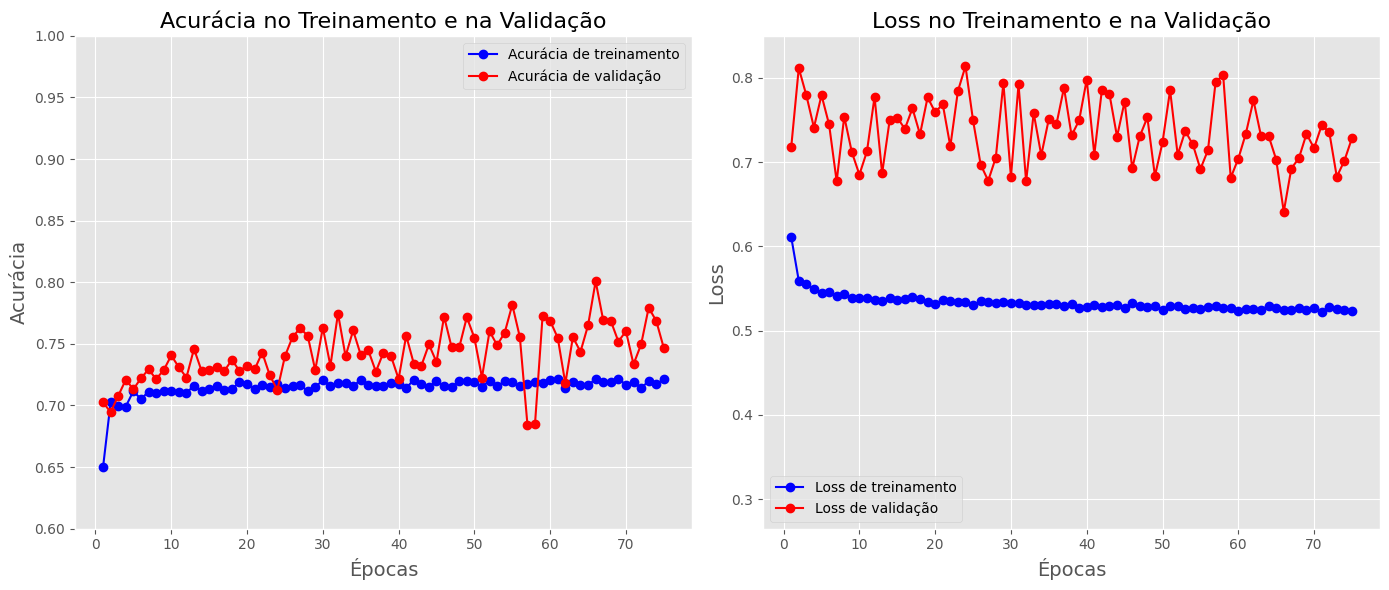

In [28]:
import matplotlib.pyplot as plt

history = history_3

# Suponha que 'history' é o retorno da função fit() do seu modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Configurações gerais de estilo
plt.style.use('ggplot')

# Plot da precisão
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='blue', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'o-', color='red', label='Acurácia de validação')
plt.title('Acurácia no Treinamento e na Validação', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(0.6,1)

# Plot da perda
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='blue', label='Loss de treinamento')
plt.plot(epochs, val_loss, 'o-', color='red', label='Loss de validação')
plt.title('Loss no Treinamento e na Validação', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(0.265,0.85)

plt.tight_layout()
plt.show()

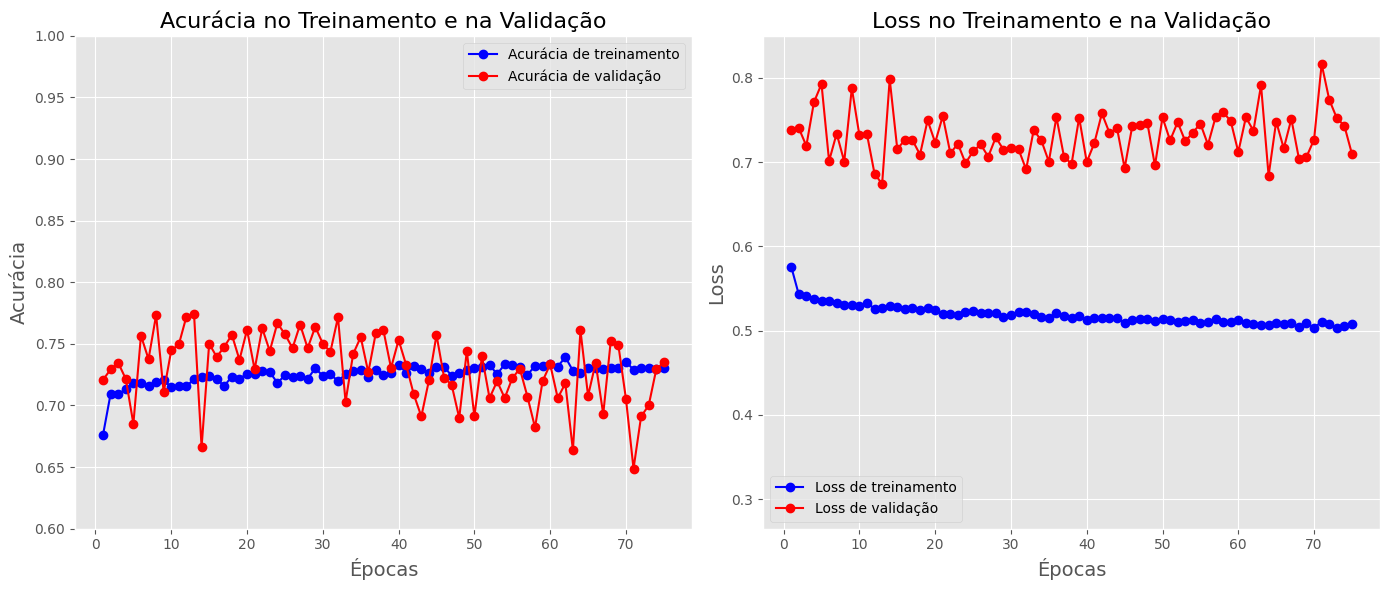

In [29]:
import matplotlib.pyplot as plt

history = history_4

# Suponha que 'history' é o retorno da função fit() do seu modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Configurações gerais de estilo
plt.style.use('ggplot')

# Plot da precisão
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'o-', color='blue', label='Acurácia de treinamento')
plt.plot(epochs, val_acc, 'o-', color='red', label='Acurácia de validação')
plt.title('Acurácia no Treinamento e na Validação', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Acurácia', fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(0.6,1)

# Plot da perda
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'o-', color='blue', label='Loss de treinamento')
plt.plot(epochs, val_loss, 'o-', color='red', label='Loss de validação')
plt.title('Loss no Treinamento e na Validação', fontsize=16)
plt.xlabel('Épocas', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.ylim(0.265,0.85)

plt.tight_layout()
plt.show()

In [25]:
def plot_cm(cm):
# Normalise
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
  fig, ax = plt.subplots(figsize=(10,10))
  sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=['no','yes'], yticklabels=['no','yes'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show(block=False)

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Resultados do modelo 0:
 [[3614   56]
 [ 356   93]]
Resultados do modelo 1:
 [[2033 1637]
 [  91  358]]
Resultados do modelo 2:
 [[3621   49]
 [ 359   90]]
Resultados do modelo 3:
 [[2541 1129]
 [ 127  322]]


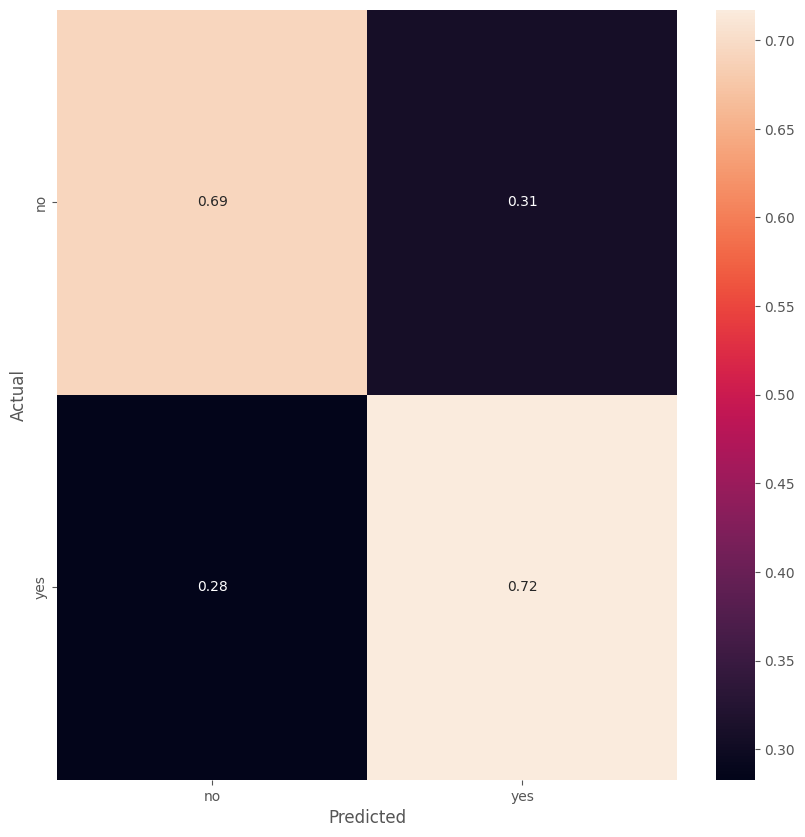

Resultados do modelo 4:
 [[2540 1130]
 [ 137  312]]


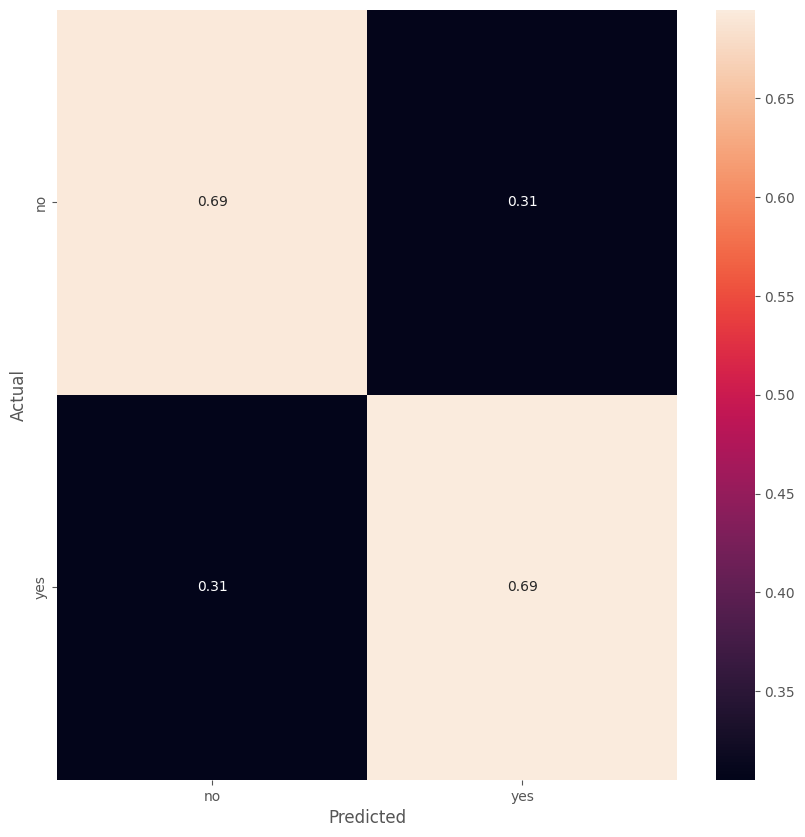

In [26]:
from sklearn.metrics import confusion_matrix
#Create confusion matrix and normalizes it over predicted (columns)
result_0 = confusion_matrix(pp_y_test, np.round(model_0.predict(pp_x_test)))
result_1 = confusion_matrix(pp_y_test, np.round(model_1.predict(pp_x_test)))
result_2 = confusion_matrix(pp_y_test, np.round(model_2.predict(pp_x_test)))
result_3 = confusion_matrix(pp_y_test, np.round(model_3.predict(pp_x_test)))
result_4 = confusion_matrix(pp_y_test, np.round(model_4.predict(pp_x_test)))

print('Resultados do modelo 0:\n', result_0)
print('Resultados do modelo 1:\n', result_1)
print('Resultados do modelo 2:\n', result_2)
print('Resultados do modelo 3:\n', result_3)
plot_cm(result_3)

print('Resultados do modelo 4:\n', result_4)
plot_cm(result_4)


1159/1159 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1159/1159 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Resultados do modelo 0:
 [[32371   507]
 [ 3251   940]]
Resultados do modelo 1:
 [[2882 1309]
 [1069 3122]]
Resultados do modelo 2:
 [[32476   402]
 [ 3099  1092]]
Resultados do modelo 3:
 [[3130 1061]
 [1200 2991]]


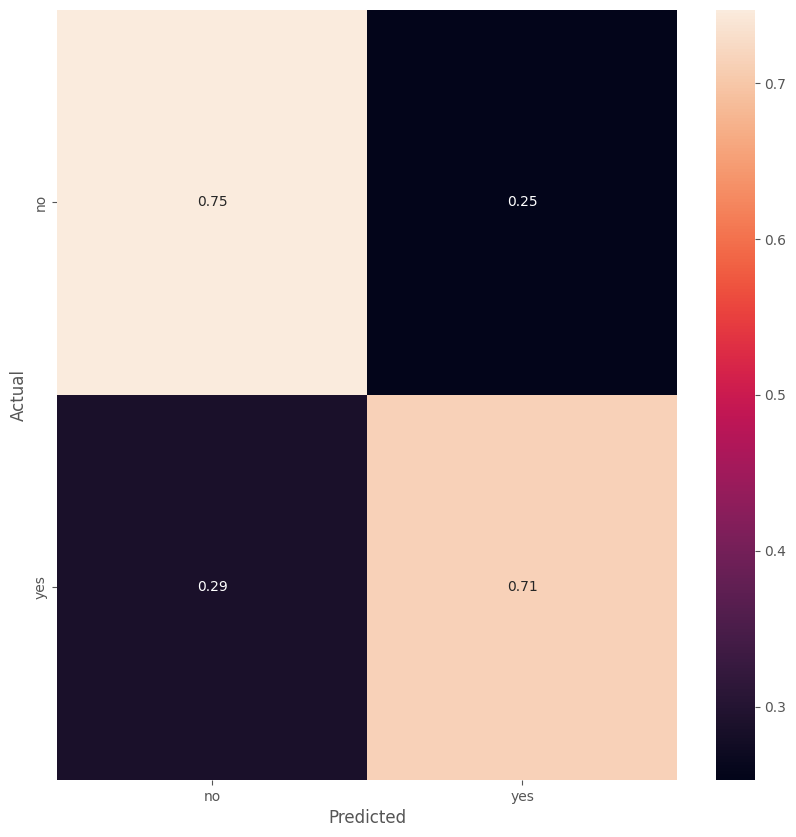

In [250]:
result_0 = confusion_matrix(pp_y_train, np.round(model_0.predict(pp_x_train)))
result_1 = confusion_matrix(pp_y_train_st, np.round(model_1.predict(pp_x_train_st)))
result_2 = confusion_matrix(pp_y_train, np.round(model_2.predict(pp_x_train)))
result_3 = confusion_matrix(pp_y_train_st, np.round(model_3.predict(pp_x_train_st)))

print('Resultados do modelo 0:\n', result_0)
print('Resultados do modelo 1:\n', result_1)
print('Resultados do modelo 2:\n', result_2)
print('Resultados do modelo 3:\n', result_3)


In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAcurácia={:0.3f}\nPrecisão={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\Acurácia={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Valores reais')
        plt.xlabel('Valores preditos' + stats_text)
    else:
        plt.xlabel(stats_text)

    if title:
        plt.title(title)

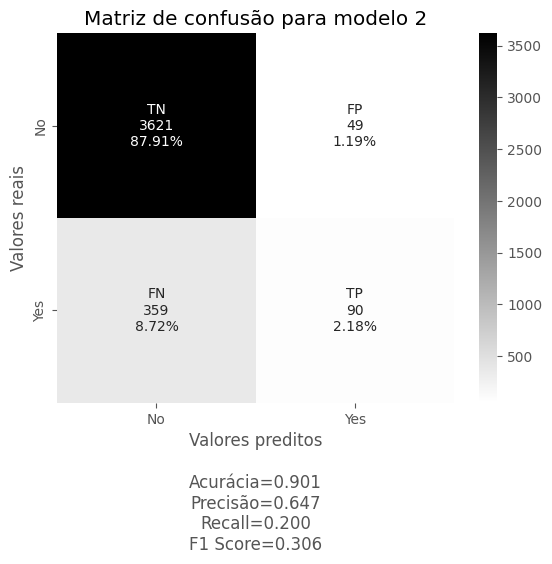

In [68]:


cf_matrix = result_2

labels = ['TN','FP','FN','TP']
categories = ['No', 'Yes']
title= 'Matriz de confusão para modelo 2'
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='binary',
                      title = title)




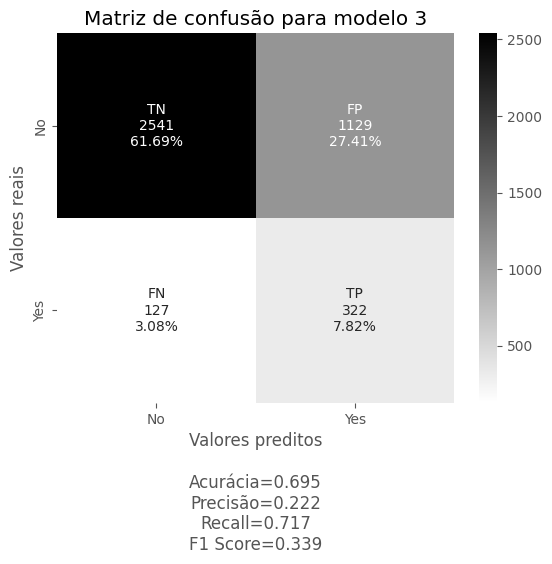

In [69]:
cf_matrix = result_3

labels = ['TN','FP','FN','TP']
categories = ['No', 'Yes']
title= 'Matriz de confusão para modelo 3'
make_confusion_matrix(cf_matrix,
                      group_names=labels,
                      categories=categories,
                      cmap='binary',
                      title = title)